<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/CIFAR_Hybrid_QNN_1_with_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 4.9MB/s 
     |████████████████████████████████| 18.0MB 170kB/s 
     |████████████████████████████████| 235kB 42.5MB/s 
     |████████████████████████████████| 215kB 43.7MB/s 
     |████████████████████████████████| 2.1MB 30.9MB/s 
     |████████████████████████████████| 1.5MB 32.2MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 194kB 40.9MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 614kB 30.2MB/s 
     |████████████████████████████████| 3.2MB 29.2MB/s 
     |████████████████████████████████| 6.3MB 27.8MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=74c3bbfbeb2e57b81a80d31c73ec65a05bc99c04a13dc8b9e0f9723e6e907e89
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py

In [11]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

To connect PyTorch to Qiskit, we need to define a function that converts tensors so obtained from PyTorch to a list so that the list could be fed into the Quantum Circuit in Qiskit.

In [ ]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [ ]:

import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

We use a 1 qubit circuit with 1 trainable parameter to create a 'Quantum Class'

In [ ]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

To measure the output (in the z basis), the expectation must be calculated, so let's test the implementation below

In [ ]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 0.39


┌───┐ ░ ┌───────────┐ ░ ┌─┐
   q_0: ┤ H ├─░─┤ RY(theta) ├─░─┤M├
        └───┘ ░ └───────────┘ ░ └╥┘
meas: 1/═════════════════════════╩═
                                 0

**Creating the quantum classical hybrid class using Pytorch**

The functions needed for backpropagation can be created by PyTorch (using the parameter shift rule). The forward and backward passes contain elements from the Qiskit class

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

## **Data loading and pre-processing**

Here , we create a simple hybrid neural network to classify images of two types ; Aeroplanes and Automobiles (labelled 0 and 1) from the CIFAR-10 dataset.

Let's first load the training data

In [ ]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)

labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


We now filter for pictures containing Aeroplanes and Automobiles (labelled 0 and 1 respectively)

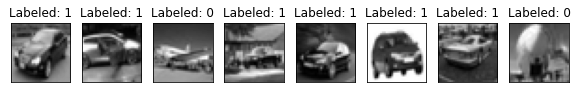

In [12]:
import numpy as np  
import matplotlib.pyplot as plt

n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
    #axes[n_samples_show - 1].imshow( tf.shape( tf.squeeze(images[0]) ),cmap='gray' )
    #plt.imshow((tf.squeeze(images[0])))
      
    #plt.imshow( tf.shape( tf.squeeze(x_train) ) )
    #axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

Now let's look at the testing data

In [14]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx] 
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=True)

Files already downloaded and verified


**Creating the hybrid Neural Network**

We create a typical Convolutional Neural Network with two fully-connected layers at the end. The value of the last neuron of the fully-connected layer is fed as the parameter  
θ
  into our quantum circuit.

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

**Now let's train the network**

We can specify any PyTorch optimiser (here we use the Adam optimiser), learning rate and cost/loss function in order to train over multiple epochs. In this instance, we use  a learning rate of 0.001 and the negative log-likelihood loss function.
We then plot the training graph. We do this for 5, 10, 20, 30 epochs

Training [20%]	Loss: -0.4838
Training [40%]	Loss: -0.5119
Training [60%]	Loss: -0.4712
Training [80%]	Loss: -0.4925
Training [100%]	Loss: -0.5569


Text(0, 0.5, 'Neg Log Likelihood Loss')

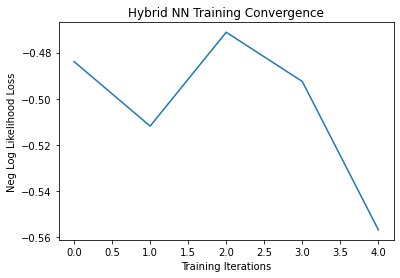

In [16]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

#Now plotting the training graph
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')


In [18]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.5559
	Accuracy: 57.0%


Training [10%]	Loss: -0.4781
Training [20%]	Loss: -0.5393
Training [30%]	Loss: -0.6002
Training [40%]	Loss: -0.6337
Training [50%]	Loss: -0.6676
Training [60%]	Loss: -0.6564
Training [70%]	Loss: -0.7034
Training [80%]	Loss: -0.6097
Training [90%]	Loss: -0.6849
Training [100%]	Loss: -0.7284


Text(0, 0.5, 'Neg Log Likelihood Loss')

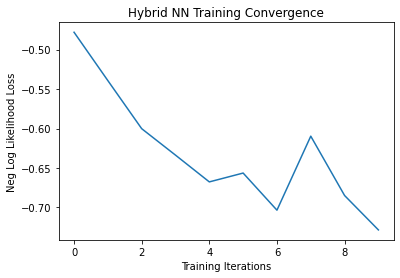

In [19]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 10
loss_list1 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list1.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list1[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list1)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [20]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.6887
	Accuracy: 68.5%


Training [7%]	Loss: -0.4813
Training [13%]	Loss: -0.5063
Training [20%]	Loss: -0.5915
Training [27%]	Loss: -0.6660
Training [33%]	Loss: -0.7238
Training [40%]	Loss: -0.7539
Training [47%]	Loss: -0.7539
Training [53%]	Loss: -0.7684
Training [60%]	Loss: -0.7934
Training [67%]	Loss: -0.7796
Training [73%]	Loss: -0.7994
Training [80%]	Loss: -0.7902
Training [87%]	Loss: -0.7914
Training [93%]	Loss: -0.7564
Training [100%]	Loss: -0.8059


Text(0, 0.5, 'Neg Log Likelihood Loss')

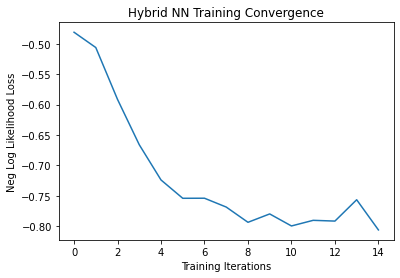

In [21]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 15
loss_list2 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list2.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list2[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list2)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [22]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.7983
	Accuracy: 84.5%


Training [5%]	Loss: -0.4961
Training [10%]	Loss: -0.5808
Training [15%]	Loss: -0.6102
Training [20%]	Loss: -0.6513
Training [25%]	Loss: -0.6665
Training [30%]	Loss: -0.7114
Training [35%]	Loss: -0.6940
Training [40%]	Loss: -0.7227
Training [45%]	Loss: -0.7625
Training [50%]	Loss: -0.7409
Training [55%]	Loss: -0.7521
Training [60%]	Loss: -0.7733
Training [65%]	Loss: -0.7697
Training [70%]	Loss: -0.7871
Training [75%]	Loss: -0.8007
Training [80%]	Loss: -0.8092
Training [85%]	Loss: -0.8251
Training [90%]	Loss: -0.8116
Training [95%]	Loss: -0.8279
Training [100%]	Loss: -0.8335


Text(0, 0.5, 'Neg Log Likelihood Loss')

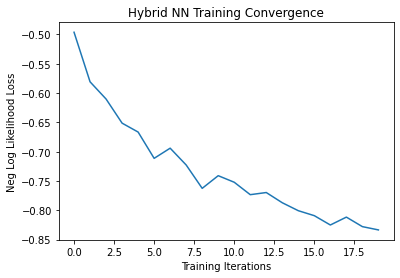

In [25]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list3 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list3.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list3[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list3)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [26]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.8126
	Accuracy: 85.5%


Training [3%]	Loss: -0.4958
Training [7%]	Loss: -0.4891
Training [10%]	Loss: -0.5213
Training [13%]	Loss: -0.5415
Training [17%]	Loss: -0.5187
Training [20%]	Loss: -0.5270
Training [23%]	Loss: -0.4932
Training [27%]	Loss: -0.5266
Training [30%]	Loss: -0.4594
Training [33%]	Loss: -0.5536
Training [37%]	Loss: -0.4857
Training [40%]	Loss: -0.5060
Training [43%]	Loss: -0.4751
Training [47%]	Loss: -0.5343
Training [50%]	Loss: -0.5546
Training [53%]	Loss: -0.5552
Training [57%]	Loss: -0.5712
Training [60%]	Loss: -0.5173
Training [63%]	Loss: -0.5098
Training [67%]	Loss: -0.5274
Training [70%]	Loss: -0.5229
Training [73%]	Loss: -0.4945
Training [77%]	Loss: -0.5258
Training [80%]	Loss: -0.5115
Training [83%]	Loss: -0.5394
Training [87%]	Loss: -0.5267
Training [90%]	Loss: -0.5083
Training [93%]	Loss: -0.4959
Training [97%]	Loss: -0.5393
Training [100%]	Loss: -0.4987


Text(0, 0.5, 'Neg Log Likelihood Loss')

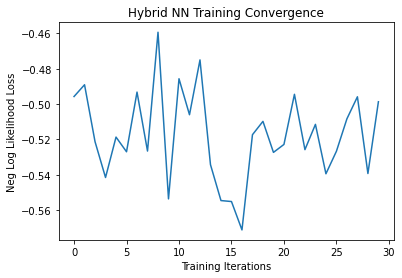

In [32]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 30
loss_list4 = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list4.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list4[-1]))
    
#Alongside, let's also plot the data
plt.plot(loss_list4)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [33]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.4983
	Accuracy: 48.0%


Testing the network